# Initial Setup

First, we need to import appropriate libraries that we will use throughout the workshop.

Note! Some of the libraries below are not directly used in the code below but will be necessary once you start experimenting.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.regularizers import l1
from matplotlib import pyplot as plt
from keras.utils import plot_model
from keras import backend
from sklearn.decomposition import PCA
from itertools import product

# Data

We will be working on a dataset that I have created from HapMap phase 3 project. In HapMap, several individuals have been genotyped that come from different parts of the world and from different ethnic backgrounds. For the sake of simplicity, I have **randomly selected 5000 autosomal** markers that we will be working with and saved them along with phenotype data (biological sex, ethnicity etc.) and a pre-computed genomic kinship matrix in the *hdf5* file format.

If you want to try another dataset, you can go for e.g., data from Lazaridis et. al. [*Genomic insights into the origin of farming in the ancient Near East*](https://www.nature.com/articles/nature19310) 2016. Nature **536**:419-424. I have pre-prepared chr1 markers at call rate of 0.99 and higher.

In [5]:
# HapMap3 randomly selected 5000 autosomal markers data
!wget -O data.hd5 https://www.dropbox.com/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc&dl=1

# Data for chr1 from Lazaridis et al.
#!wget -O data.hd5 https://www.dropbox.com/scl/fi/kck4puyi1qmuzr65bgdbn/HumanOriginsPublic2068_geno_chr1.h5?rlkey=xp4nfljz0c2za9ihriletxx3x&dl=1


In [6]:
# Extract genotypes, phenotypes and genomic kinship matrix from hdf5 file
orig_geno = pd.read_hdf('data.hd5', key = 'geno')
# orig_pheno = pd.read_hdf('data.hd5', key = 'pheno') #python version >3.8
# orig_gkin = pd.read_hdf('data.hd5', key = 'gkin')


In [4]:
# Let's have a look at the genotypes data
orig_geno.info()
orig_geno.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1184 entries, NA19919 to NA19099
Columns: 5000 entries, rs416967 to rs2806497
dtypes: int64(5000)
memory usage: 45.2+ MB


,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,2,1,0,1,1,0,0,1,1,1,...,0,1,0,0,1,0,1,1,1,0
NA19916,1,0,0,1,1,0,1,1,2,1,...,0,0,0,0,0,1,1,1,1,0
NA19835,0,0,1,1,0,1,0,2,2,1,...,0,1,0,0,0,0,2,2,0,0
NA20282,1,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,2,0,0
NA19703,0,0,0,0,1,1,0,0,0,2,...,0,1,1,0,1,1,1,1,2,0


In [ ]:
# Examine phenotypes
orig_pheno.head()

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA
NA19703,NA19703,1,2368,0,0,0,African ancestry in SW USA


In [ ]:
# Look at the genomic kinship matrix
orig_gkin.iloc[0:4, ] # similarity matrix, 1.000 to themselves

,NA19919,NA19916,NA19835,NA20282,NA19703,NA19902,NA19901,NA19908,NA19914,NA20287,...,NA18853,NA19173,NA19171,NA19140,NA18859,NA19119,NA18860,NA19207,NA19103,NA19099
NA19919,1.000000,0.956045,0.991299,0.998115,0.966539,0.984490,0.969456,0.720372,0.993620,0.987785,...,0.973502,0.976022,0.974834,0.977329,0.977305,0.969765,0.964101,0.984822,0.978650,0.978933
NA19916,0.956045,1.000000,0.987325,0.997055,0.972959,0.988437,0.983771,0.950670,0.987508,0.965180,...,0.979353,0.966666,0.965574,0.972000,0.987989,0.965478,0.984434,0.950259,0.958601,0.971893
NA19835,0.991299,0.987325,1.000000,0.973136,0.974283,0.981403,0.982401,0.978460,0.990013,1.003244,...,0.971275,0.984477,0.967848,0.983973,0.969998,0.979433,0.974723,0.980122,0.988978,0.974627
NA20282,0.998115,0.997055,0.973136,1.000000,0.997064,1.002880,0.989643,0.987173,1.004836,0.977272,...,0.983496,0.988047,0.976974,0.980222,0.975953,0.973370,0.977145,0.984446,0.991740,0.992266


In [ ]:
# Check whether we have missing genotypes in our data
print("Missing genotypes per marker: \n", np.sum(orig_geno.isna().sum()))

Missing genotypes per marker: 
 0


Since neural networks require numeric values as input, we do not need to do anything -- our genotypes are already encoded as minor allele counts. However, we know that it is best for the networks to get input from the range [0, 1], thus we shall re-code our genotypes so that they are bound between zero and one.

Now, one of the alleles is encoded as 0, meaning that for this particular genotype the bias term can take over the weight (y = 0*w_0 + b). While true in previous implementations of tensorflow, this "bias hitchhiking" is no longer a concern.

In [ ]:
orig_geno

,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,2,1,0,1,1,0,0,1,1,1,...,0,1,0,0,1,0,1,1,1,0
NA19916,1,0,0,1,1,0,1,1,2,1,...,0,0,0,0,0,1,1,1,1,0
NA19835,0,0,1,1,0,1,0,2,2,1,...,0,1,0,0,0,0,2,2,0,0
NA20282,1,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,2,0,0
NA19703,0,0,0,0,1,1,0,0,0,2,...,0,1,1,0,1,1,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,1,0,1,0,1,1,1,1,1,2,...,0,0,0,0,0,0,0,1,0,0
NA18860,1,0,0,1,1,0,0,1,2,1,...,1,1,0,0,0,0,1,0,0,1
NA19207,2,0,0,0,1,0,1,1,2,0,...,0,0,0,0,0,1,0,1,1,0
NA19103,1,0,1,0,0,0,1,1,2,1,...,0,0,0,0,0,0,2,1,2,0


In [3]:
# recode the data snp 0/1/2 -> 0/0.5/1.0
geno = orig_geno.replace([0, 1.0, 2.0], [0, 0.5, 1.0])
#geno.fillna(0, inplace = True)
#print(geno.isna().sum())
geno


,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,1.0,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0.5,...,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0
NA19916,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0
NA19835,0.0,0.0,0.5,0.5,0.0,0.5,0.0,1.0,1.0,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
NA20282,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0
NA19703,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0,...,0.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,0.5,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
NA18860,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,0.5,...,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
NA19207,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0
NA19103,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0


# Training Phase

Now, we will follow some best machine learning practises and randomly split our data into two sets: the training set and the test set. The training set will be used to train our neural network, i.e. to optimize network weights while the latter will be set aside so that it is NEVER used in the training phase. This set will be used to objectively assess performance of our model at the very end.

## Question 1

Do you think that this random split of the original dataset is good enough? What should you take into consideration when setting a test set aside?



In [4]:
train = geno.sample(frac = 0.8, random_state = 42) # 80% of our individuals will go to the training set
test = geno.drop(train.index)
pheno = orig_pheno.set_index(keys = 'id')
train_pheno = pheno[pheno.index.isin(train.index)]
test_pheno = pheno.drop(train.index)
train.reset_index()
test.reset_index()
train_pheno.reset_index()
test_pheno.reset_index()

# NOTE! A bit unexpectedly after setting some test data aside, we now start without
# proper test set and will entrust internal validation.
# Why? Well, we do not have so many individuals to spare for the test set. However,
# when you have more data than in this toy example, go for a proper test set!
train = geno

# Print some info about the resulting split
print("Original data:", orig_geno.shape)
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Original data: (1184, 5000)
	 - training set: (1184, 5000)
	 - test set: (237, 5000)


# PCA

Before we even start training our autoencoder model, it'd be good to have some benchmark to compare to. Below, we will do a very simple PCA on raw genotypes, not even making use of the kinship matrix.

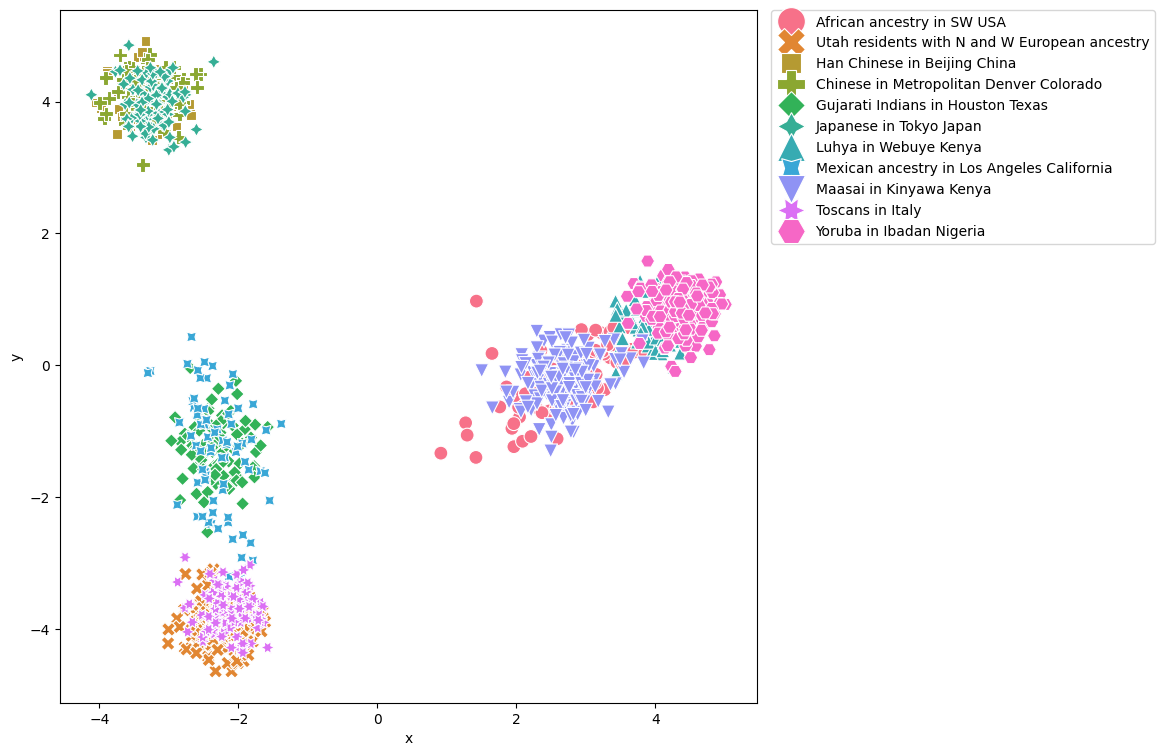

In [ ]:
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
pop = pheno.iloc[:,5]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (9,9))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100, legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

As you can see, simple PCA separates our individuals into a couple of clear clusters: *Africa* in the E(ast) part of the plot, *China and Japan* in the NW part and ethnicities of *mostly European descent* end up in the SW part. While it is easy for PCA to separate Maasai from Yoruba, people of Chinese descent cannot be easily told apart from Japanese using this approach.

In [5]:
# For Keras framework, we need to convert our data types a bit
train_tensor = train.to_numpy()
test_tensor = test.to_numpy()
original_dim = train_tensor.shape[1]
latent_dim = 2 # dimentionality of our latent space
print(type(train_tensor))

<class 'numpy.ndarray'>


# Autoencoder Model

Below, we will build an **autoencoder model** using functional interface provided by the Keras framework. Keras, in turn, will talk to Tensorflow framework that enables us to build, train and use neural networks.

In [6]:
print("Original dimensionality (no. SNP markers):", original_dim)
input = keras.Input(shape = (original_dim,))
output = input

h = layers.Dense(units = 500, activation = 'relu')(input)
h = layers.BatchNormalization()(h)
h = layers.Dropout(rate = 0.05)(h)
h = layers.Dense(units = 250, activation = 'relu')(h)
h = layers.Dense(units = 25, activation = 'relu')(h)
latent = layers.Dense(units = latent_dim, name = 'latent')(h)
encoder = keras.Model(input, latent, name='encoder')

latent_inputs = keras.Input(shape=(latent_dim,))
h = layers.Dense(units = 25, activation = 'relu')(latent_inputs)
h = layers.Dense(units = 250, activation = 'relu')(h)
h = layers.Dense(units = 500, activation = 'relu')(h)
dec_output = layers.Dense(original_dim, activation='sigmoid')(h)
decoder = keras.Model(latent_inputs, dec_output, name='decoder')

output = decoder(encoder(input))
ae_model = keras.Model(input, output, name='Vanilla_AE')

Original dimensionality (no. SNP markers): 5000


Keras.utils provides a very convenient way of visualizing models:

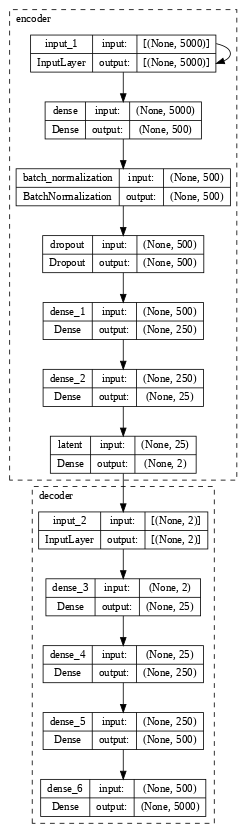

In [7]:
plot_model(ae_model, show_shapes=True, expand_nested = True, dpi=58)

Once we have checked that the model looks as we wanted it to look, we can compile it. We will change two hyperparameters of the model from their defaults:

*   we set custom loss function. Here, we want our loss function to measure how far the decoded points are from where they are in input. Ideal autoencoder should perfectly reproduce the input on the output,
*   we also use ADAM as our optimizer. Without going into details, this should be your off-the-shelf optimizer in most cases.



In [8]:
hp_loss_fn = keras.losses.MeanSquaredError()
hp_optimizer = 'adam'
ae_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer
)
ae_model.summary(expand_nested = True)

Model: "Vanilla_AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 encoder (Functional)        (None, 2)                 2634077   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 5000)]            0        |
|                                                               |
| dense (Dense)              (None, 500)               2500500  |
|                                                               |
| batch_normalization (Batc  (None, 500)               2000     |
| hNormalization)                                               |
|                                                               |
| dropout (Dropout)          (None, 500)               0        |
|                                                       

Finally, we can train our model:

In [10]:
hp_epochs = 30
hp_batch_size = 64
hp_val_split = 0.2

autoencoder = ae_model.fit(
                      x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      validation_split = hp_val_split,
                      verbose = 2
                      )

Epoch 1/30
15/15 - 7s - loss: 0.1363 - val_loss: 0.0795 - 7s/epoch - 465ms/step
Epoch 2/30
15/15 - 0s - loss: 0.0736 - val_loss: 0.0714 - 122ms/epoch - 8ms/step
Epoch 3/30
15/15 - 0s - loss: 0.0673 - val_loss: 0.0704 - 122ms/epoch - 8ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0659 - val_loss: 0.0681 - 124ms/epoch - 8ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0652 - val_loss: 0.0677 - 111ms/epoch - 7ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0645 - val_loss: 0.0672 - 129ms/epoch - 9ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0641 - val_loss: 0.0670 - 139ms/epoch - 9ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0641 - val_loss: 0.0671 - 113ms/epoch - 8ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0640 - val_loss: 0.0670 - 126ms/epoch - 8ms/step
Epoch 10/30
15/15 - 0s - loss: 0.0639 - val_loss: 0.0670 - 117ms/epoch - 8ms/step
Epoch 11/30
15/15 - 0s - loss: 0.0638 - val_loss: 0.0674 - 115ms/epoch - 8ms/step
Epoch 12/30
15/15 - 0s - loss: 0.0638 - val_loss: 0.0668 - 124ms/epoch - 8ms/step
Epoch 13/30
15/15 - 0s - l

In [27]:
train_tensor # predict themselves

array([[1. , 0.5, 0. , ..., 0.5, 0.5, 0. ],
       [0.5, 0. , 0. , ..., 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, ..., 1. , 0. , 0. ],
       ...,
       [1. , 0. , 0. , ..., 0.5, 0.5, 0. ],
       [0.5, 0. , 0.5, ..., 0.5, 1. , 0. ],
       [0. , 0. , 0.5, ..., 0.5, 0. , 0. ]])

Once the model is trained, we can have a look at its performance:

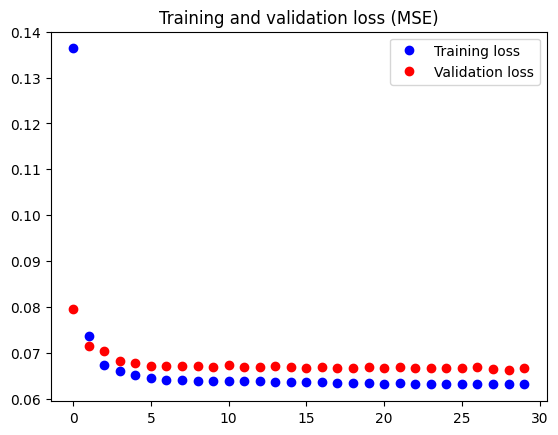

In [28]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss (MSE)')
plt.legend()
plt.show()

All right, so now our model has been trained and we need to visualize our data in low dimension by using neurons in from the bottleneck layer. The easiest way is to extract the whole trained encoder and run our input through it once again to get embeddings (i.e. our individuals represented in 2D latent space).


In [14]:
for i in ae_model.layers:
  print(i)
# input encoder decoder

trained_encoder = keras.Model(ae_model.input, ae_model.layers[1].get_layer("latent").output)
trained_encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense (Dense)               (None, 500)               2500500   
                                                                 
 batch_normalization (Batch  (None, 500)               2000      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 25)                6275      
                                                           

37/37 [==============================] - 0s 3ms/step
[[ 4.824453  11.899643 ]
 [ 4.399272  11.069808 ]
 [ 0.8703839 12.536917 ]
 ...
 [ 3.8028016 11.423444 ]
 [ 4.562019  11.12439  ]
 [ 5.3165345 11.144365 ]]


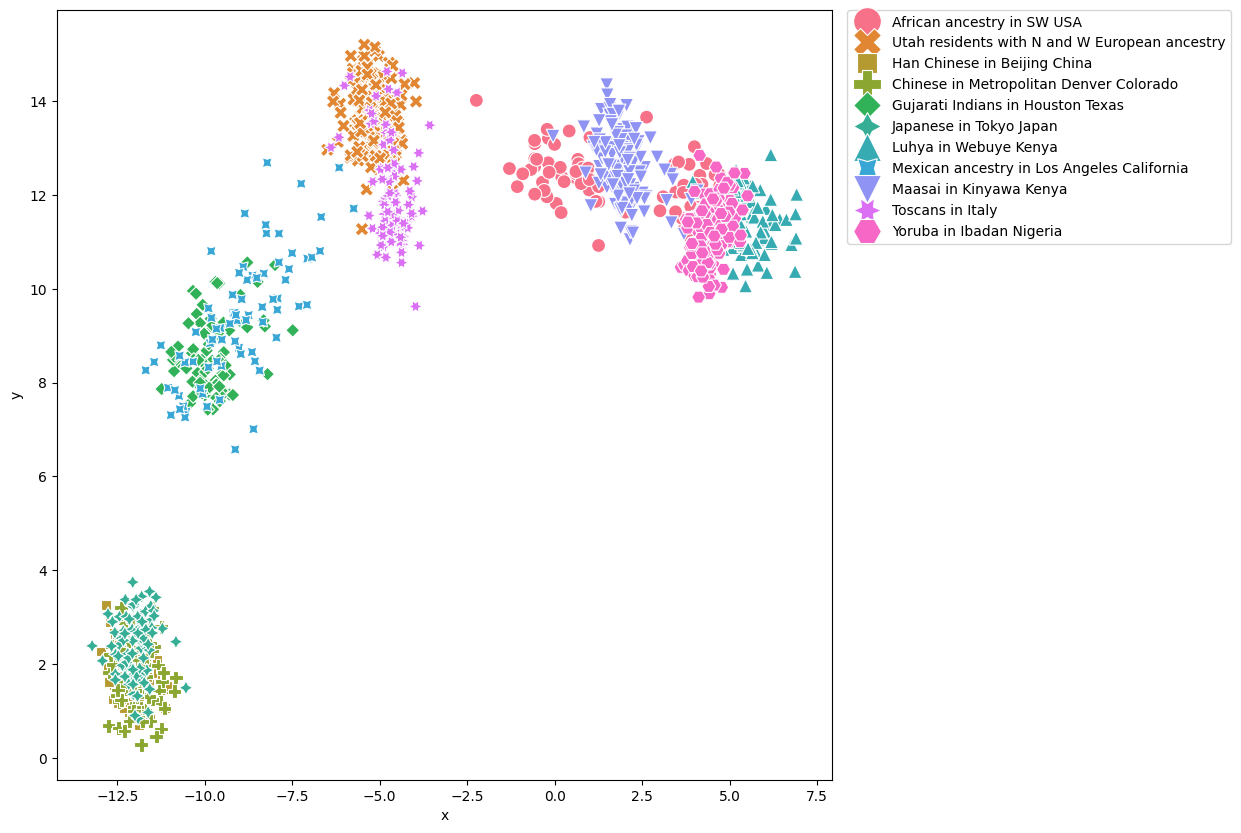

In [15]:
geno_tensor = geno.to_numpy()
# geno_dim = geno_tensor.shape[1]
# input = keras.Input(shape = (geno_dim,))


embedded_points = trained_encoder.predict(geno_tensor)
print(embedded_points)

x = embedded_points[:,0]
y = embedded_points[:,1]
pop = pheno.iloc[:,5]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

## Questions set 2
* Try to see what happens if you add an extra layer with, say 1500 units to the
model.
* What are pros and what are potential cons of such approach?
* What do you think of having only 2 dimensions in the latent space? Why did we choose this number? Can you think of anny different, perhaps better, choice?

# VAE

Now it is, perhaps, time to go generative and build a variational variant of our autoencoder.

We will need a special layer here, the so-called sampling layer (you remember the reparametrization trick from the lecture, right?).


In [42]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return z_mean + tf.exp(z_log_sigma) * epsilon

# Encoder
input = keras.Input(shape = (original_dim,))

h = layers.Dense(units = 1500, activation = 'relu')(input)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 500, activation = 'relu')(h)
h = layers.Dense(units = 250, activation = 'relu')(h)
h = layers.Dense(units = 25, activation = 'relu')(h)
# Bottleneck
z_mean = layers.Dense(latent_dim, name = 'z_mean')(h)
z_log_sigma = layers.Dense(latent_dim, name = 'z_sigma')(h)
# Lambda layer with specified output shape
z_sampling = layers.Lambda(sampling, name='z_sampling', output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = keras.Model(input, [z_mean, z_log_sigma, z_sampling], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
h = layers.Dense(units = 25, activation = 'relu')(latent_inputs)
h = layers.Dense(units = 250, activation = 'relu')(h)
h = layers.Dense(units = 500, activation = 'relu')(h)
h = layers.Dense(units = 1500, activation = 'relu')(h)
dec_output = layers.Dense(original_dim, activation='sigmoid')(h) # 每一个 genotype dosage 在我们归一化之后都是 0-1 之间的
decoder = keras.Model(latent_inputs, dec_output, name='decoder')

# instantiate VAE model
output = decoder(encoder(input)[2])
vae_model = keras.Model(input, output, name='VAE')

We also need a custom loss function that has two constraints:
* reconstructed space has to be as close to input as possible (like in vanilla autoencoder),
* points in our latent points have to be distributed as close to a given distribution (here a random normal) as possible (this is what KL divergence measures)

In [64]:
# Define VAE loss in a custom layer
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_sigma, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = keras.losses.MeanSquaredError()(inputs, reconstructed) * original_dim

        # KL divergence loss
        kl_loss = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
        kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)

        # Add losses to the model
        self.add_loss(tf.reduce_mean(reconstruction_loss + kl_loss))
        return reconstructed

vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer='adam')
# vae_model.summary()

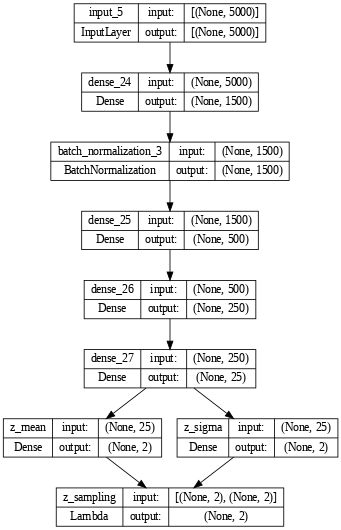

In [55]:
plot_model(encoder, show_shapes=True, show_layer_names = True, dpi = 60)

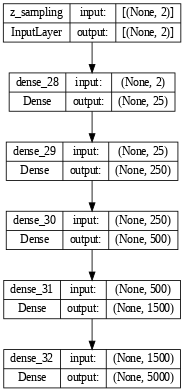

In [56]:
plot_model(decoder, show_shapes=True, expand_nested = True, dpi = 60)

In [59]:
hp_epochs = 30
hp_batch_size = 64
hp_val_split = 0.2

vae_model.fit(train_tensor, train_tensor,
        epochs = hp_epochs,
        batch_size = hp_batch_size,
        shuffle = True,
        validation_split = hp_val_split)

Epoch 1/30
15/15 [==============================] - 6s 44ms/step - loss: 321.6812 - val_loss: 334.8930
Epoch 2/30
15/15 [==============================] - 0s 18ms/step - loss: 319.6915 - val_loss: 332.6722
Epoch 3/30
15/15 [==============================] - 0s 20ms/step - loss: 317.5922 - val_loss: 332.8997
Epoch 4/30
15/15 [==============================] - 0s 19ms/step - loss: 316.8788 - val_loss: 332.0855
Epoch 5/30
15/15 [==============================] - 0s 20ms/step - loss: 317.1165 - val_loss: 334.9560
Epoch 6/30
15/15 [==============================] - 0s 23ms/step - loss: 316.7767 - val_loss: 334.4540
Epoch 7/30
15/15 [==============================] - 0s 20ms/step - loss: 316.8129 - val_loss: 333.2340
Epoch 8/30
15/15 [==============================] - 0s 24ms/step - loss: 316.5234 - val_loss: 332.9630
Epoch 9/30
15/15 [==============================] - 0s 26ms/step - loss: 316.0981 - val_loss: 333.9192
Epoch 10/30
15/15 [==============================] - 0s 20ms/step - loss:

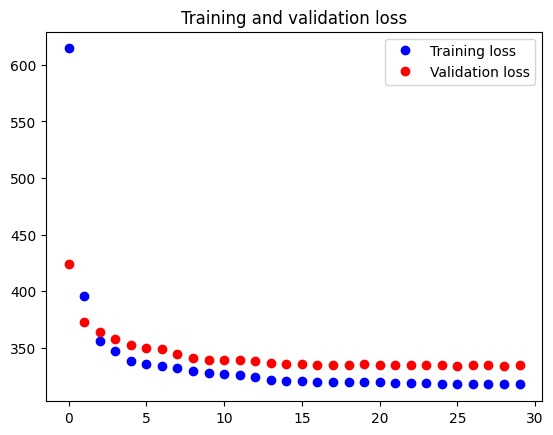

In [36]:
loss = vae_model.history.history['loss']
val_loss = vae_model.history.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

37/37 [==============================] - 0s 2ms/step
[array([[ 0.4542708 , -0.39170787],
       [ 0.66848344, -0.49869573],
       [ 0.96351314, -0.2663304 ],
       ...,
       [ 0.6540794 , -0.54566276],
       [ 0.7639255 , -0.65381426],
       [ 0.7633024 , -0.761688  ]], dtype=float32), array([[-1.3436952, -1.9159296],
       [-1.3280267, -2.0984418],
       [-1.9875401, -2.6198323],
       ...,
       [-1.3975251, -2.214871 ],
       [-1.2624038, -2.245863 ],
       [-1.4244275, -2.5290046]], dtype=float32), array([[ 0.51289624, -0.3832476 ],
       [ 0.9224974 , -0.7834796 ],
       [ 1.1837008 , -0.269629  ],
       ...,
       [ 0.16174263, -0.454938  ],
       [ 0.9257421 , -0.63414115],
       [ 1.129432  , -0.7912983 ]], dtype=float32)]


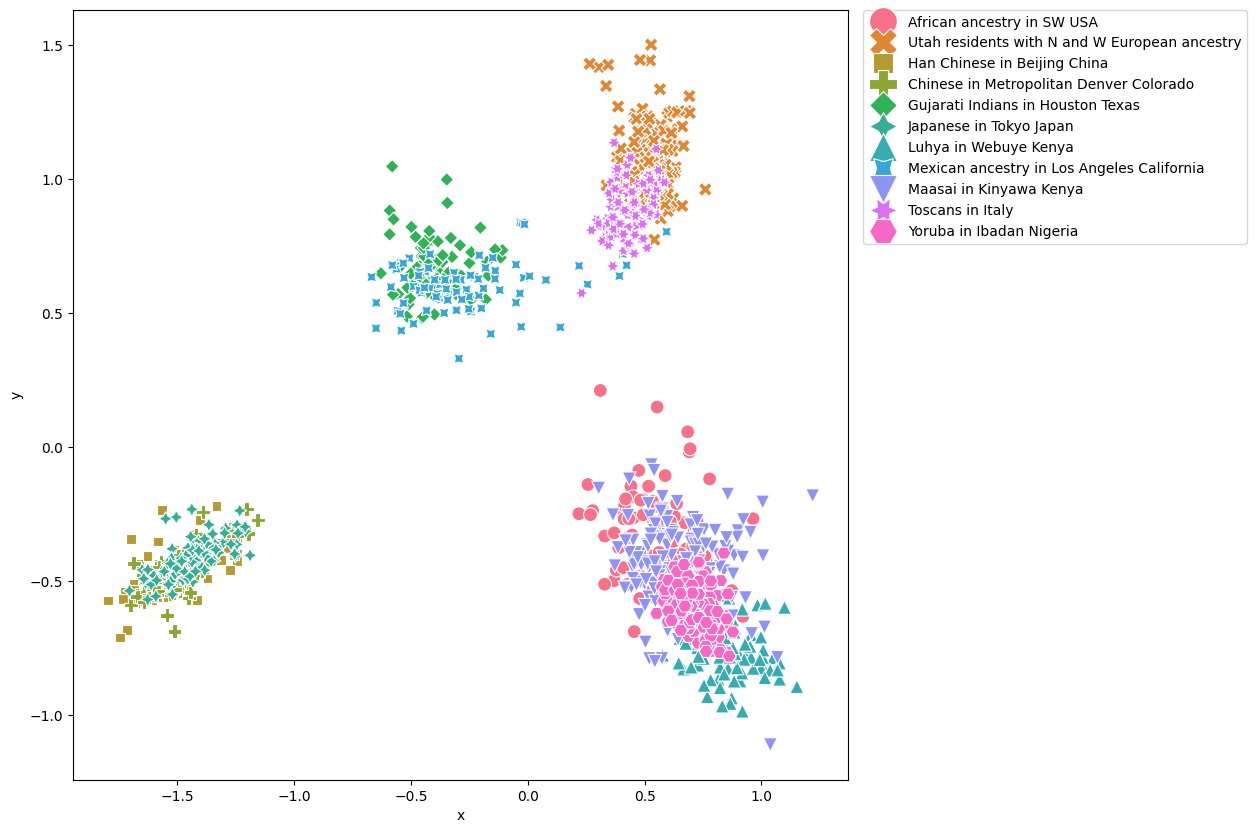

In [37]:
embedded_points = encoder.predict(geno_tensor)
print(embedded_points)

x = embedded_points[0][:,0]
y = embedded_points[0][:,1]
pop = pheno.iloc[:,5]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Now, let us create some 10 imaginary individuals around a given point in the latent space, here [0.4, 0.5].

In [75]:
N_ind = 10
center = [0, 0.0]
cx = tf.random.normal(shape = [N_ind], mean = -0.6, stddev = 0.1)
cy = tf.random.normal(shape = [N_ind], mean = 0.3, stddev = 0.1)
z_sample = np.column_stack((cx, cy))
z_sample

array([[-0.53508407,  0.20252055],
       [-0.60285586,  0.3518592 ],
       [-0.61976665,  0.26648268],
       [-0.53255236,  0.34404352],
       [-0.6386026 ,  0.17400138],
       [-0.6521005 ,  0.38227367],
       [-0.50323695,  0.10337666],
       [-0.85168004,  0.30623057],
       [-0.69197845,  0.2854763 ],
       [-0.55097795,  0.14598295]], dtype=float32)

In [76]:
# Let's thread those artificial individuals through the decoder part of the model
decoded = decoder.predict(z_sample,)
decoded

1/1 [==============================] - 0s 19ms/step


array([[0.23778439, 0.1143064 , 0.10612893, ..., 0.5717306 , 0.38798204,
        0.00981204],
       [0.26200277, 0.1349277 , 0.06578068, ..., 0.56013495, 0.36239094,
        0.0087078 ],
       [0.24515328, 0.12108296, 0.08579328, ..., 0.5682315 , 0.37732866,
        0.00896825],
       ...,
       [0.24973843, 0.12826371, 0.07895794, ..., 0.5673116 , 0.3745225 ,
        0.00874636],
       [0.24720593, 0.12396521, 0.08133405, ..., 0.56762886, 0.3750647 ,
        0.00874332],
       [0.23034646, 0.10954349, 0.11073568, ..., 0.5726128 , 0.39233673,
        0.00928972]], dtype=float32)

In [77]:
# And see what are their genotypes
new_geno = np.zeros(shape = decoded.shape)
new_geno[decoded <= 0.33] = 0
new_geno[np.logical_and(decoded > 0.33, decoded < 0.66)] = 1
new_geno[decoded > 0.66] = 2
print(new_geno)

[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]


38/38 [==============================] - 0s 2ms/step


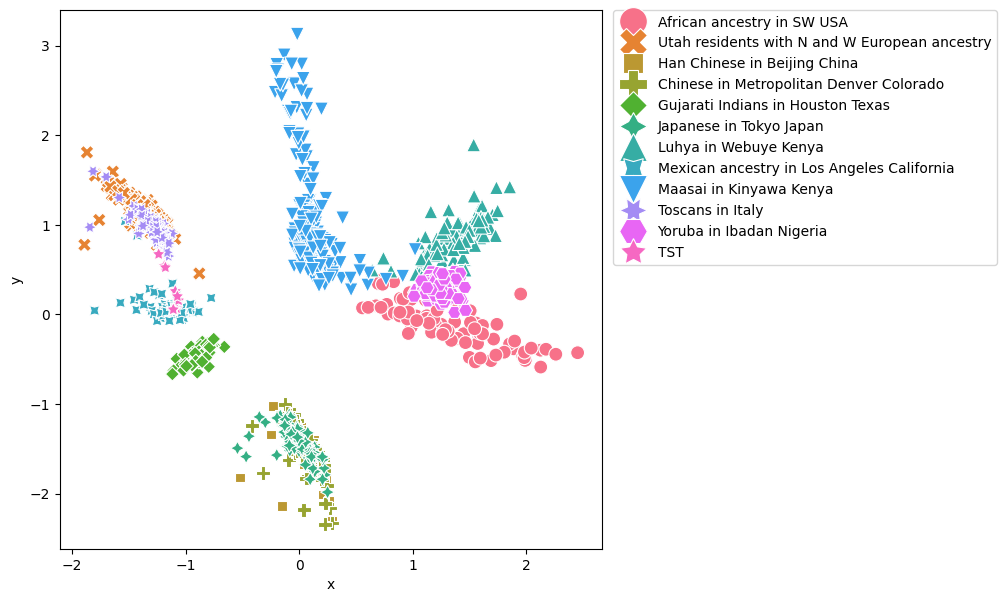

In [81]:
# And now, we can see where our individuals ended up in the embedded space.
x_encoded = encoder.predict(np.row_stack((geno_tensor, decoded)), batch_size=32)
x = x_encoded[0][:, 0]
y = x_encoded[0][:, 1]
pop_list = [pheno['population'], pd.Series(np.repeat('TST', new_geno.shape[0]))]
pop = pd.concat(pop_list)
data_tmp = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7, 7))
sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

## Questions set 3
* Remove the layer with 1500 units from the VAE model and see how does it
affect the result. What do you think is happening here?
* What do you think of using some other types of layers in our AE/VAE models, e.g. convolutional layers. Any possible benefits you can think of?